In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
from scipy import signal

# Prep

In [51]:
import pathlib
outdir = pathlib.Path('output')

outdir.mkdir(exist_ok=True)

# Download and process data

In [4]:
cases_url = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
deaths_url = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv"

In [5]:
provinces = ['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'SA']

In [6]:
province = 'GP'
outformat = 'pdf'

In [7]:
def read_source(url):
    df = pd.read_csv(url, parse_dates=['date'], index_col='date', dayfirst=True).rename(columns={'total': 'SA'})
    del df['YYYYMMDD']
    df = df[provinces] #.melt(var_name='province')
    return df

In [8]:
cases = read_source(cases_url)
deaths = read_source(deaths_url)

In [9]:
newcases = cases[province].diff()
newdeaths = deaths[province].diff()

## Predict the future from the past

In [10]:
import datetime

In [11]:
today = datetime.date.today()

In [12]:
shifts = {
    'GP': 22,
    'SA': 24,
}

In [13]:
startdate = '2020-11-01'
shift = shifts[province]

In [14]:
shifted = newcases[startdate:].shift(shift*7, '1D')
shifted_rolling = shifted.rolling('7D').mean()

In [15]:
mappednewcases = shifted[today:]

In [16]:
combined = pd.DataFrame({'cases': pd.concat([newcases, mappednewcases]), 'deaths': newdeaths})['2020-06':]

# Simple delayed death model

In [17]:
ksize = 101

In [18]:
days = np.arange(1, ksize)

In [19]:
case_fatality = 0.025
shape = 4
scale = 5

In [20]:
pars = [case_fatality, shape, scale]

In [21]:
def kernel_func(case_fatality, shape, scale):
    return stats.distributions.gamma.pdf(days, shape, scale=scale)*case_fatality

In [22]:
def model(pars):
    case_fatality, shape, scale = pars
       
    kernel = np.zeros(ksize*2-1)

    kernel[ksize:] = kernel_func(case_fatality, shape, scale)
    
    prediction = signal.convolve(combined.cases, kernel, mode='same')
    
    return prediction

In [23]:
def plotmodel(case_fatality, shape, scale, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.title
    kernel = kernel_func(case_fatality, shape, scale)
    ax.plot(kernel)
    ax.set(
        xlabel='Days',
        ylabel='Chance of dying',
        title='Death model',
    )
    ax.text(scale, 0, f'Case fatality = {case_fatality:0.2%}')
#     ax.axvline(scale)

In [24]:
pars = [case_fatality, shape, scale]

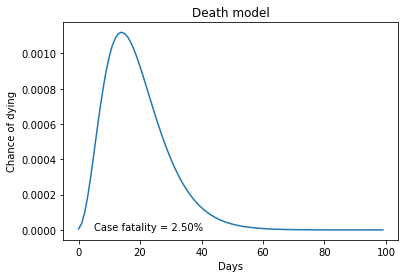

In [25]:
plotmodel(*pars)

In [26]:
prediction = model(pars)

In [27]:
kernel = kernel_func(*pars)

In [28]:
longprediction = signal.convolve(combined.cases, kernel)

In [29]:
combined['prediction'] = prediction

In [30]:
def error(pars):
    prediction = model(pars)
    combined['prediction'] = prediction
    return ((deaths[province] - combined['prediction'].cumsum())**2).sum()

In [31]:
from scipy.optimize import minimize

In [32]:
opt = minimize(error, pars, bounds=((0, 0.05), (1, 10), (1, 10)))

In [33]:
opt.x

array([ 0.02507909,  2.74531438, 10.        ])

In [34]:
prediction = model(opt.x)

In [35]:
combined['prediction'] = prediction

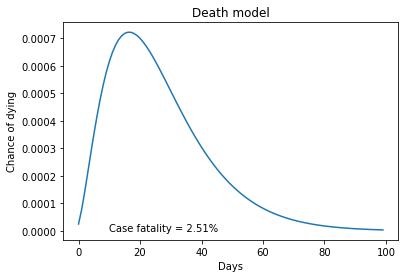

In [36]:
plotmodel(*opt.x)

<AxesSubplot:xlabel='date'>

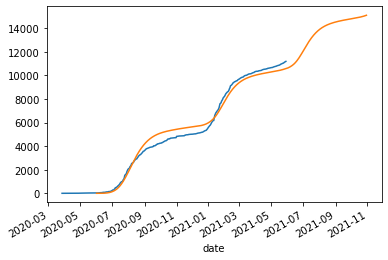

In [37]:
deaths[province].plot()
combined['prediction'].cumsum().plot()

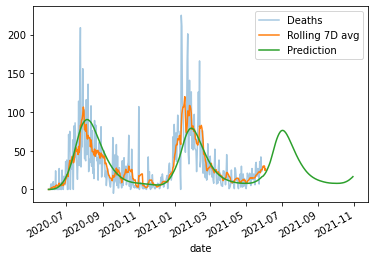

In [38]:
combined['deaths'].plot(alpha=0.4, label='Deaths')
combined['deaths'].rolling('7D').mean().plot(label='Rolling 7D avg')
combined['prediction'].plot(label='Prediction')
plt.legend()

In [39]:
peak_rate = newcases.max()
cutoff = 0.3

In [40]:
predicted_third_wave = (shifted_rolling[:'2021-06-15'] - peak_rate*cutoff).abs().idxmin()
predicted_third_wave

Timestamp('2021-05-26 00:00:00')

In [41]:
deathroll = '7D'

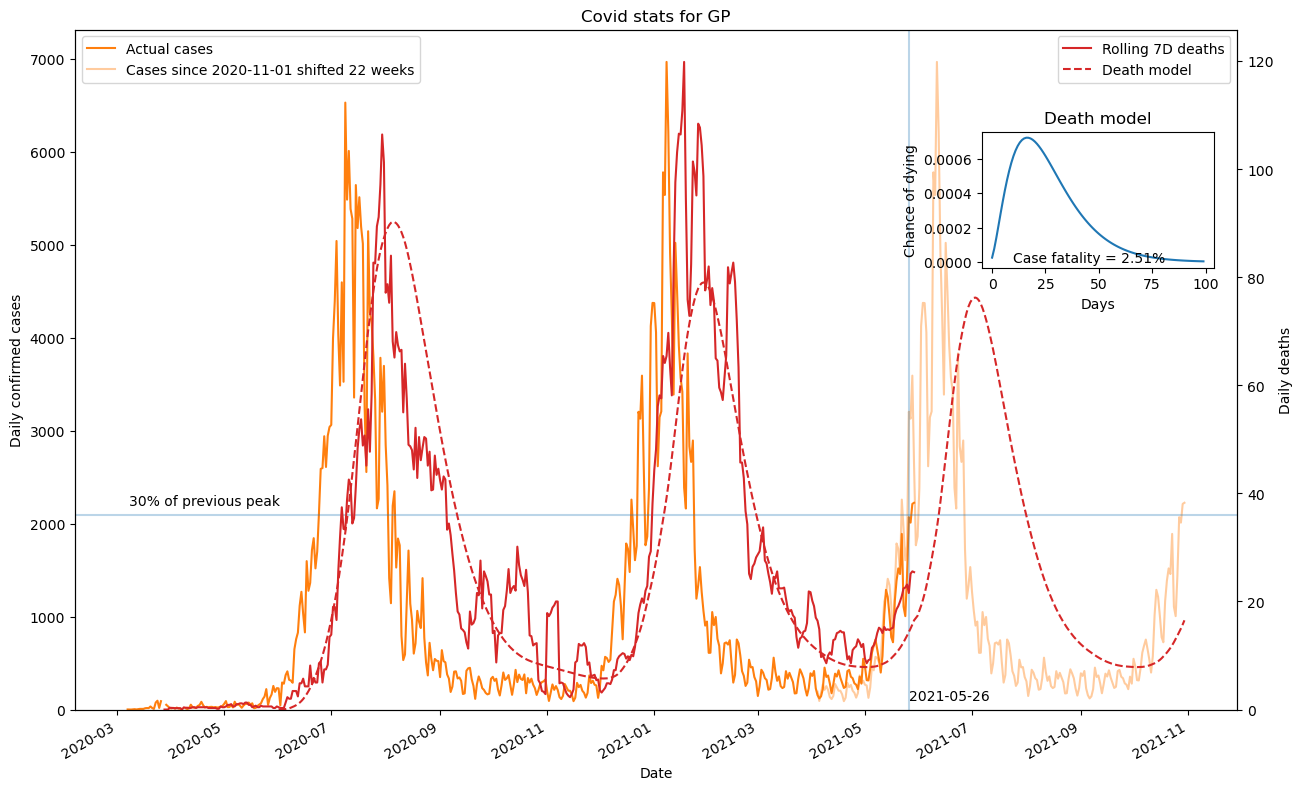

In [50]:
fig, ax_cases = plt.subplots(figsize=(15, 10), dpi=100)
ax_deaths = ax_cases.twinx()
# ax_deaths.spines['right'].set_edgecolor('C3')
newcases.plot(ax=ax_cases, color='C1', label='Actual cases')
shifted.plot(ax=ax_cases, color='C1', alpha=0.4, label=f'Cases since {startdate} shifted {shift} weeks')

newdeaths.rolling(deathroll).mean().plot(ax=ax_deaths, label=f'Rolling {deathroll} deaths', color='C3')
combined['prediction'].plot(ax=ax_deaths, label="Death model", color='C3', style='--')
# newcases.rolling('7D').mean().plot()
ax_cases.axhline(peak_rate*cutoff, alpha=0.3)
ax_cases.axvline(predicted_third_wave, alpha=0.3)
ax_cases.set(
    xlabel='Date',
    ylabel=f'Daily confirmed cases',
    title=f"Covid stats for {province}",
)
ax_cases.set_ylim(bottom=0)
ax_deaths.set_ylim(bottom=0)
ax_deaths.set(
    ylabel='Daily deaths'
)
ax_cases.legend(loc="upper left")
ax_deaths.legend(loc="upper right")
ax_cases.text(newcases.index[2], peak_rate*cutoff*1.05, f'{cutoff:.0%} of previous peak')
ax_cases.text(predicted_third_wave, 100, predicted_third_wave.date())
ax_model = ax_cases.inset_axes([0.78, 0.65, 0.2, 0.2])
plotmodel(*opt.x, ax_model)
plt.savefig(f'output/covid_{province}_{today}.{outformat}')